# Оптимизация маркетинговых затрат в Яндекс.Афише

## План работы:

- Изучение и предобработка данных
- Построение отчётов и рассчет следующих метрик, отобразив на графиках, как эти метрики отличаются по устройствам и по рекламным источникам, и как они меняются во времени:
    - Анализ метрик продукта:  
         - Количество посетителей в период времени(день, неделю, месяц) 
         - Количество сессий в день
         - Продолжительность одной сессии
         - Retention Rate пользователей

    - Анализ метрик продаж:
         - Какой период между первым визитом и первой покупкой 
         - Сколько покупок совершают пользователи за период времени()
         - Средний чек пользователя
         - Общая прибыль с покупателя (Life Time Value, LTV)

    - Анализ метрик затрат на маркетинг:
        - Затраты на рекламу за весь перид с разбивкой по источникам и по времени
        - Затраты на  привлечение одного покупателя из каждого источника 
        - Насколько окупились расходы на каждый источник рекламы? (ROMI)¶


In [1]:
#импортирование библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
sns.set()

#pd опции 
pd.set_option('display.float_format', lambda x: '%.2f' % x)
plt.style.use('seaborn-bright') # выбор стиля матплот

import warnings
warnings.filterwarnings("ignore")

In [2]:
# функции

def firstlook_df(df):
    '''
    Функция для датафрейма df выводит:
    - первые и последние 5 строчек таблицы, 
    -общую информацию о таблице,
    -количество дубликатов и пропусков   
    '''
    separator_line =25*('--')
    print(separator_line)
    print('Первые 5 строк таблицы:')
    print(separator_line)
    display(df.head())
    print(separator_line)
    print('Последние 5 строк таблицы:')
    print(separator_line)
    display(df.tail())
    
    print(separator_line)
    print('Общая информация о данных:')
    print(separator_line)
    display(df.info()) 
    
    print(separator_line)
    print('Проверка на наличие дубликатов и пропусков:')
    print(separator_line) 
    print('Количество строк-дубликатов = ', df.duplicated().sum())
    for column in df.columns:
        n_nulls = df[column].isnull().sum()
        print(f'Количество пропусков в столбце {column} = {n_nulls}')

    
def add_date_units(df, date_column):
    '''
    добавляет в датафрейм (df) колонки года, месяца, недели и дня 
    на основе даты из столбца date_column
    '''
    df = df.copy()
    df['year'] =df[date_column].astype('datetime64[Y]')
    df['month'] =df[date_column].astype('datetime64[M]')   
    df['week'] =df[date_column].astype('datetime64[W]')
    df['day'] =df[date_column].astype('datetime64[D]')    
    return df

def show_df(df):
    '''
    выводит на экран датафрейм и инфо
    '''
    df = df.copy()
    display(df.info())
    display(df.head())
    return df

# 1. Изучение и предобработка данных

Загружаем данные о визитах, заказах и расходах в соответствующие переменные: 

In [3]:
#загружаем лог сервера с информацией о посещениях сайта
visits_df = pd.read_csv('visits_log.csv')  
#загружаем информацию о заказах                   
orders_df = pd.read_csv('orders_log.csv') 
#загружаем информацию о затратах на маркетинг
costs_df = pd.read_csv('costs.csv') 

Изучаем таблицу с данными о визитах с помощью функции firstlook_df -она показывает первые и последние 5 записей, информацию о таблице, дубликатах и пропусках.

In [4]:
# изучаем таблицу  посещениях сайта
visits_df.pipe(firstlook_df)

--------------------------------------------------
Первые 5 строк таблицы:
--------------------------------------------------


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


--------------------------------------------------
Последние 5 строк таблицы:
--------------------------------------------------


,Device,End Ts,Source Id,Start Ts,Uid
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485
359399,touch,2017-09-10 13:13:19,2,2017-09-10 13:13:00,18396128934054549559


--------------------------------------------------
Общая информация о данных:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

--------------------------------------------------
Проверка на наличие дубликатов и пропусков:
--------------------------------------------------
Количество строк-дубликатов =  0
Количество пропусков в столбце Device = 0
Количество пропусков в столбце End Ts = 0
Количество пропусков в столбце Source Id = 0
Количество пропусков в столбце Start Ts = 0
Количество пропусков в столбце Uid = 0


- в таблице 359399 строк и 5 столбцов, нет пропусков и дубликатов;
- тип данных в столбцах 'End Ts' и 'Start Ts' строковый, его необходимо заменить на тип datetime;
- так же для удобства использования нужно названия столбцов привести к нижнему регистру и заменить пробелы в них на подчеркивание;
- далее нам понадобятся столбцы с годом, месяцем, неделей и днем сессии, добавляем их функцией add_date_units

In [5]:
# предобработка
#  приведем к нижнему регистру названия колонок,
visits_df.columns = map(str.lower,visits_df.columns)

#переименуем колонки с пробелами в названиях, заменим тип данных на datetime
# добавим столбцы год, месяц, неделю и день начала сессии
visits_df = visits_df.rename(columns = {'end ts':'end_ts', 
                                        'source id':'source_id', 
                                        'start ts':'start_ts'})\
                    .assign(
                            end_ts = lambda x: pd.to_datetime(x['end_ts']),
                            start_ts = lambda x: pd.to_datetime(x['start_ts']),
                        )\
                    .pipe(add_date_units, 'start_ts')\
                    .pipe(show_df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
 5   year       359400 non-null  datetime64[ns]
 6   month      359400 non-null  datetime64[ns]
 7   week       359400 non-null  datetime64[ns]
 8   day        359400 non-null  datetime64[ns]
dtypes: datetime64[ns](6), int64(1), object(1), uint64(1)
memory usage: 24.7+ MB


None

,device,end_ts,source_id,start_ts,uid,year,month,week,day
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-01-01,2017-12-01,2017-12-21,2017-12-27


Изучаем таблицу с данными о заказах с помощью функции firstlook_df

In [6]:
# изучаем таблицу  заказов
orders_df.pipe(firstlook_df)

--------------------------------------------------
Первые 5 строк таблицы:
--------------------------------------------------


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


--------------------------------------------------
Последние 5 строк таблицы:
--------------------------------------------------


,Buy Ts,Revenue,Uid
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247
50414,2018-06-01 00:02:00,3.42,83872787173869366


--------------------------------------------------
Общая информация о данных:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

--------------------------------------------------
Проверка на наличие дубликатов и пропусков:
--------------------------------------------------
Количество строк-дубликатов =  0
Количество пропусков в столбце Buy Ts = 0
Количество пропусков в столбце Revenue = 0
Количество пропусков в столбце Uid = 0


**Вывод**

- в таблице 50415 строк и 3 столбца, нет пропусков и дубликатов;
- тип данных в столбцах 'Buy Ts' строковый, его необходимо заменить на тип datetime;
- так же, как для таблицы visits_df,  нужно названия столбцов привести к нижнему регистру и заменить пробелы в них на подчеркивание;
- далее нам понадобятся столбцы с годом, месяцем, неделей и днем сессии, добавляем их функцией add_date_units.

In [7]:
# предобработка 
#  приведем к нижнему регистру названия колонок, 
orders_df.columns = map(str.lower,orders_df.columns)
#переименуем колонки с пробелами в названиях,
orders_df = orders_df.rename(columns = ({'buy ts':'buy_ts'}))
# заменим тип данных на datetime
orders_df['buy_ts'] = pd.to_datetime(orders_df['buy_ts'])

#добавляем столбцы год, месяц, неделю и день покупки
orders_df = orders_df.pipe(add_date_units, 'buy_ts')\
                     .pipe(show_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
 3   year     50415 non-null  datetime64[ns]
 4   month    50415 non-null  datetime64[ns]
 5   week     50415 non-null  datetime64[ns]
 6   day      50415 non-null  datetime64[ns]
dtypes: datetime64[ns](5), float64(1), uint64(1)
memory usage: 2.7 MB


None

,buy_ts,revenue,uid,year,month,week,day
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-01-01,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-01-01,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-01-01,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-01-01,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-01-01,2017-06-01,2017-06-01,2017-06-01


Изучаем таблицу с данными о маркетинговых затратах с помощью функции firstlook_df

In [8]:
# изучаем таблицу маркетинговых затрат
costs_df.pipe(firstlook_df)

--------------------------------------------------
Первые 5 строк таблицы:
--------------------------------------------------


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


--------------------------------------------------
Последние 5 строк таблицы:
--------------------------------------------------


,source_id,dt,costs
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15
2541,10,2018-05-31,17.60


--------------------------------------------------
Общая информация о данных:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

--------------------------------------------------
Проверка на наличие дубликатов и пропусков:
--------------------------------------------------
Количество строк-дубликатов =  0
Количество пропусков в столбце source_id = 0
Количество пропусков в столбце dt = 0
Количество пропусков в столбце costs = 0


 **Вывод**
 
 - в таблице 2542 строк и 3 столбца, пропусков и дубликатов нет
 - аналогично предыдущим таблицам переименуем столбец 'dt' на 'day', заменим тип данных столбца('day') на datetime и добавим год, месяц и неделю

In [9]:
costs_df = costs_df.rename(columns = ({'dt': 'day'}))
costs_df['day'] = pd.to_datetime(costs_df['day'])

#добавляем столбцы год, месяц, неделю и день затрат
costs_df = costs_df.pipe(add_date_units, 'day'). pipe(show_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   day        2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
 3   year       2542 non-null   datetime64[ns]
 4   month      2542 non-null   datetime64[ns]
 5   week       2542 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1)
memory usage: 119.3 KB


None

,source_id,day,costs,year,month,week
0,1,2017-06-01,75.20,2017-01-01,2017-06-01,2017-06-01
1,1,2017-06-02,62.25,2017-01-01,2017-06-01,2017-06-01
2,1,2017-06-03,36.53,2017-01-01,2017-06-01,2017-06-01
3,1,2017-06-04,55.00,2017-01-01,2017-06-01,2017-06-01
4,1,2017-06-05,57.08,2017-01-01,2017-06-01,2017-06-01


#  2. Анализ данных и рассчет метрик

## 2.1. Анализ метрик продукта

### 2.1.1. Количество посетителей в день, неделю, месяц

 Посчитаем и построим график количества посетителей в день, в неделю и месяц (всего и с разбивкой по устройствам):

Среднее количество пользователей в день 908
Среднее количество пользователей в день (DAU), устройство touch = 253
Среднее количество пользователей в день (DAU), устройство desktop = 659


,day,uid
day,,
2018-03-30,1,131
2018-03-31,1,1


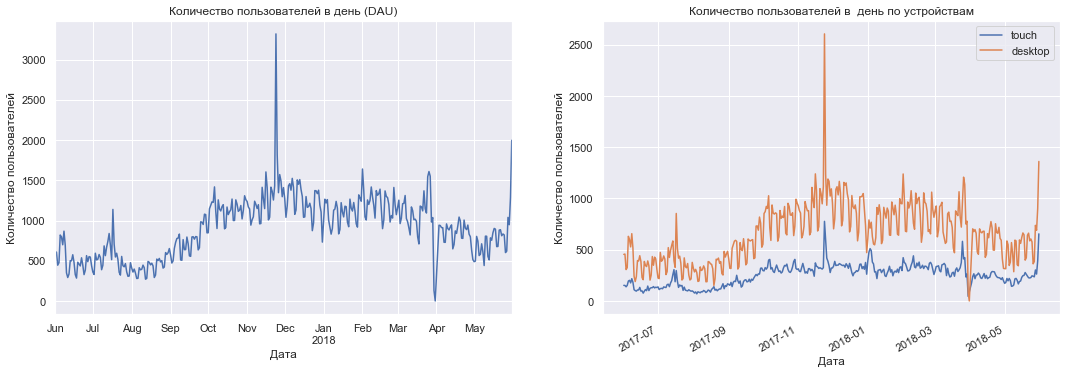

In [10]:
sns.set()
# 
# пользователи с разбивкой по устройствам

fig, ax = plt.subplots(1, 2, figsize = (18,6))
ax = ax.flatten()

# все визиты

period_visits = visits_df.pivot_table(index = 'day', values = 'uid', aggfunc  = 'nunique')
period_visits.index = period_visits.index.to_period("d")
print('Среднее количество пользователей в день {0:.0f}'.format(period_visits.mean()[1]))

period_visits.plot(y = 'uid', ax = ax[0], grid = True, legend = None)

ax[0].set_title('Количество пользователей в день (DAU)')
ax[0].set_ylabel('Количество пользователей')
ax[0].set_xlabel('Дата')

for device in visits_df['device'].unique():
    device_visits = visits_df[visits_df['device'] == device].groupby('day').agg({'uid':'nunique'})
    device_visits.plot(ax = ax[1], grid = True)
    print('Среднее количество пользователей в день (DAU), устройство {0} = {1:.0f}'.format( device,  device_visits.mean()[0]))

ax[1].legend(visits_df['device'].unique())
ax[1].set_title('Количество пользователей в  день по устройствам')
ax[1].set_ylabel('Количество пользователей')
ax[1].set_xlabel('Дата')

# 
display(period_visits.query('uid <200'))


- Среднее количество пользователей в день (DAU) = 908. По графику виден большой пик в декабре, я думаю, что скорее всего это связано с Новым годом - длинными выходными,  детскими каникулами и елками. У сервиса есть сезонность - летом среднее количество пользователей меньше среднего (колеблется около 500), а зимой выше(колеблется в районе 1000) - летом меньше спектаклей, концертов и меньше интереса у пользователей - больше других развлечений, я думаю, это больше всего влияет на сезонность. 

- Количество пользователей по устройствам:
     - Среднее количество пользователей в день, устройство touch = 253
     - Среднее количество пользователей в день, устройство desktop = 659
     
 В среднем в 3 раза чаще пользователи заходят в сервис через компьютер(desktop) - это для них либо привычнее, либо удобнее,  отчасти от того, что большинство людей сейчас работает за компьютером как минимум восьмичасовой рабочий день, соответственно чаще заходят с него на Афишу, так и в плане интерфейса.  Возможно мобильная версия сайта или приложение недостаточно user-friendly, опять же из дальнейшего анализа видно, что людей совершающих повторные покупки меньше 5 %, для одного заказа мало кто будет устанавливать приложение на телефон.
 
 - Общее среднее количество пользователей не должно быть равно сумме по двум устройствам, так как один и тот же пользователь может зайти на сайт с разных устройств и будет посчитан дважды в разных устройствах, но так как чаще всего пользователи совершают 1 сессию в день - общее среднее количество пользователей почти равно сумме. 
 
- В данных есть один день(2018-03-31) с одной единственной записью и 2018-03-30 c всего 130 записями, это явно проблема в данных - что-то потерялось/не записалось, не работал сайт в эти дни?

Среднее количество пользователей в неделю (WAU) = 5724
Среднее количество пользователей в неделю (WAU):
device
desktop   4135.75
touch     1637.26
dtype: float64
Среднее количество пользователей в месяц (MAU) = 23228
Среднее количество пользователей в месяц (MAU):
device
desktop   16724.92
touch      6825.92
dtype: float64


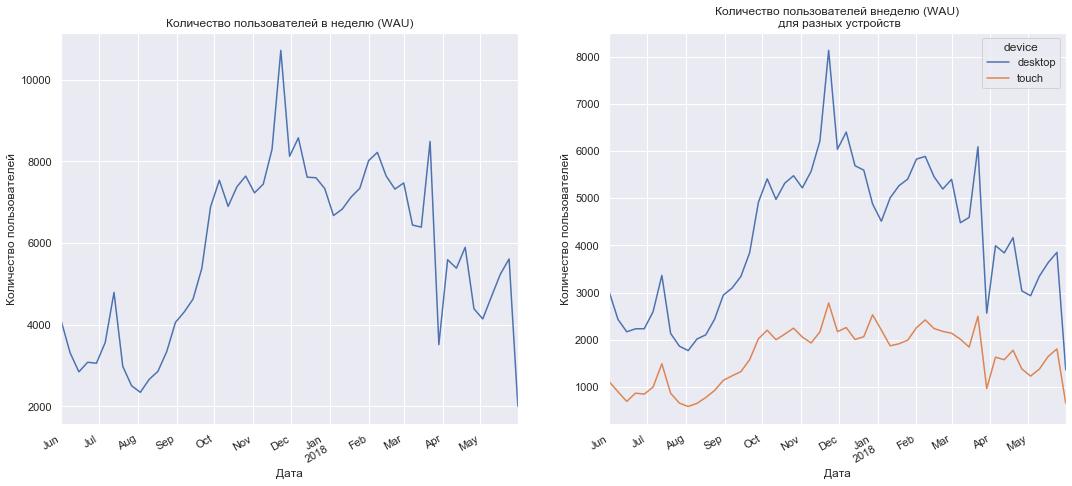

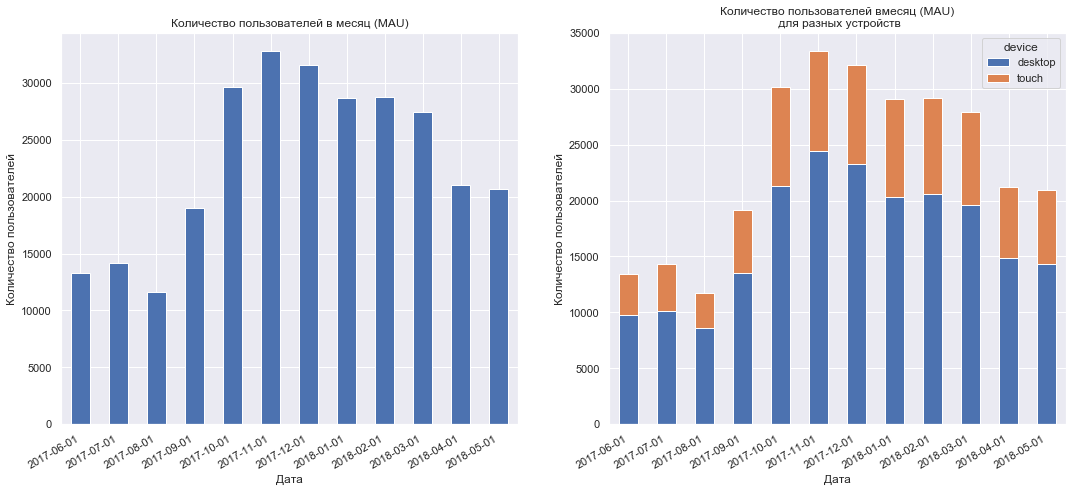

In [11]:
# количество визитов по устройствам в неделю и месяц
# перевод названий столбцов для оформления графиков
translate_period = {'day': 'день (DAU)',
                    'week': 'неделю (WAU)',
                    'month': 'месяц (MAU)'
                    }
#строим два графика рядом - общее количество и количество с разбивкой по устройствам.

for period in ['week', 'month']:
    
    fig, ax = plt.subplots(1, 2, figsize = (18,8))
    ax = ax.flatten()
    # все визиты
    period_visits = visits_df.pivot_table(index = period, values = 'uid', aggfunc  = 'nunique')    
    
    print('Среднее количество пользователей в {0} = {1:.0f}'.format(translate_period[period], period_visits.mean()['uid']))
    
    period_visits.index = period_visits.index.to_period("d")   
    
    if period == 'week':        
        period_visits.plot(y = 'uid', ax = ax[0], grid = True, legend = None)  # строим простой график для недель
    else:
        period_visits.plot.bar(y = 'uid', ax = ax[0], grid = True, legend = None) #строим barplot для месяца
        
    ax[0].set_title('Количество пользователей в '+ translate_period[period])
    ax[0].set_ylabel('Количество пользователей')
    ax[0].set_xlabel('Дата')
    
    # c разбивкой по устройствам
    device_visits  =  visits_df.pivot_table(index = period, columns = 'device', values = 'uid', aggfunc  = 'nunique')
    print('Среднее количество пользователей в {0}:'.format(translate_period[period]))
    print(device_visits.mean())
    
    device_visits.index = device_visits.index.to_period("d")
       
    if period == 'week':
        device_visits.plot(ax = ax[1], grid = True)
    else:
        device_visits.plot.bar(ax = ax[1], grid = True, stacked = True)
    
    #display(source_visits)
    ax[1].set_title('Количество пользователей в'+ translate_period[period]+ '\n для разных устройств')
    ax[1].set_ylabel('Количество пользователей')
    ax[1].set_xlabel('Дата')
 
        
    fig.autofmt_xdate()

- Общее среднее количество пользователей в неделю (WAU) = 5724.42. По устройствам:

    - desktop =  4135.75
    - touch   =  1637.26


- Общее среднее количество пользователей в месяц (MAU) = 23228.42. По устройствам:

    - desktop  = 16724.92
    - touch    =  6825.92
    
- На графиках заметен стабильный рост количества пользователей с августа по октябрь, потом некоторое плато и большой пик в декабре,  с особенно выделяющейся неделей в конце, затем количество пользователей стабильно высокое до конца марта, где оно начинает уменьшаться, достигая минимума в августе.

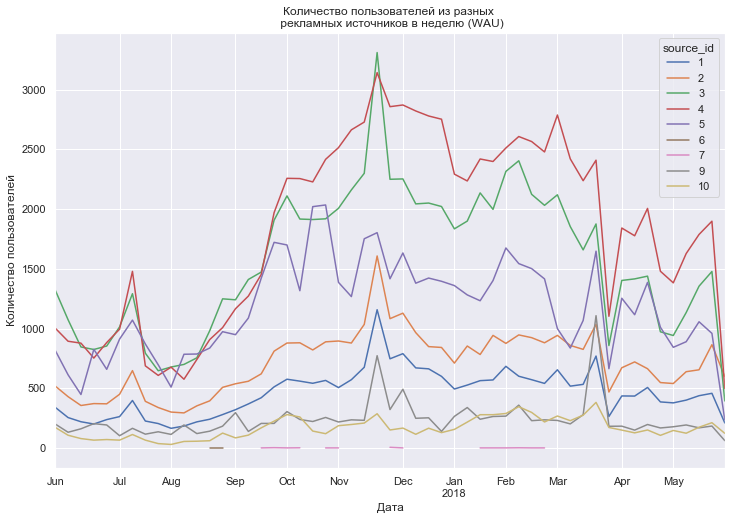

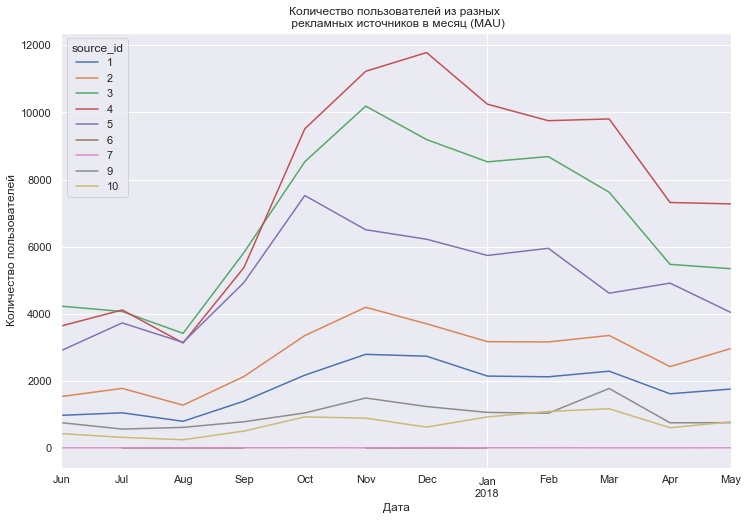

In [12]:
# количество пользователей по источникам рекламы

for period in ['week', 'month']:
    fig, ax = plt.subplots(figsize = (12,8))
    source_visits  =  visits_df.query('day != "2018-03-31"').pivot_table(index = period, columns = 'source_id', values = 'uid', aggfunc  = 'nunique')
    
    #print('Среднее количество пользователей в {0} по источникам = '.format(translate_period[period]))
    #print(source_visits.mean(axis = 0).sort_values(ascending = False))
    
    source_visits.plot(ax = ax, grid = True)
    
    ax.set_title('Количество пользователей из разных \n рекламных источников в '+ translate_period[period])
    ax.set_ylabel('Количество пользователей')
    ax.set_xlabel('Дата')
    

Полученные графики близки по форме с общими графиками количества пользователей, но их сложно понимать. Мне показалось интересным построить как менялось процентное соотношение пользователей из разных источников в течение года.

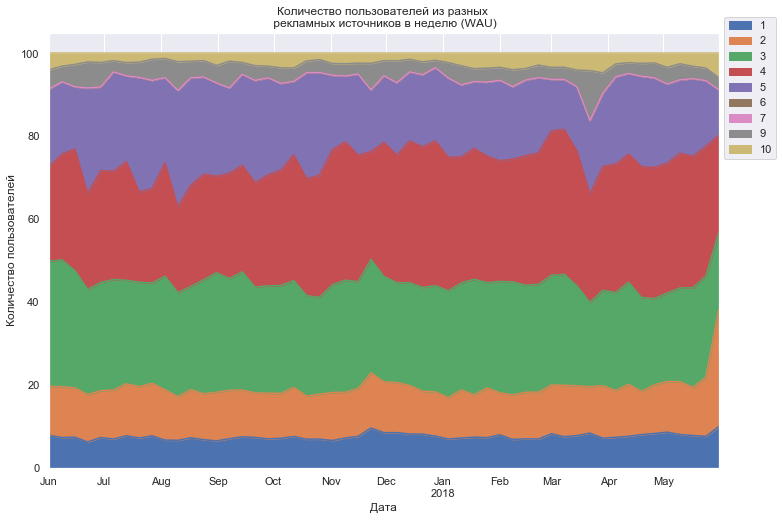

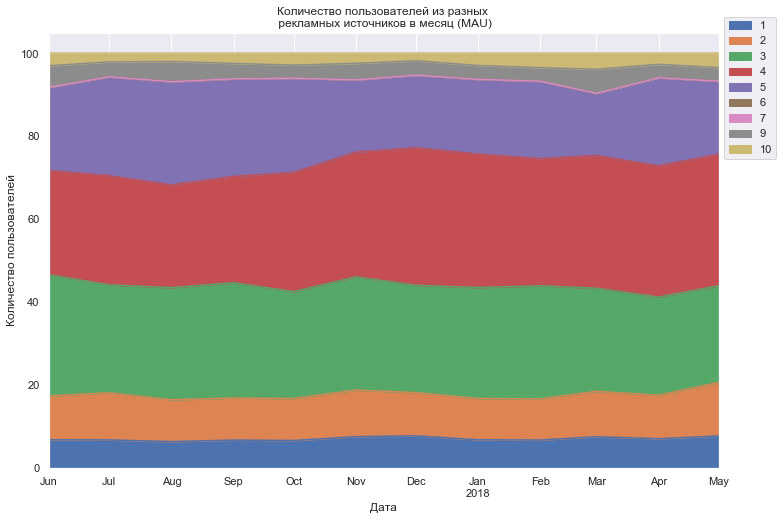

In [13]:
# количество пользователей по источникам рекламы в процентном соотношении

for period in ['week', 'month']:
    fig, ax = plt.subplots(figsize = (12,8))
    source_visits  =  visits_df.query('day != "2018-03-31" and day != "2018-03-30"').pivot_table(index = period, columns = 'source_id', values = 'uid', aggfunc  = 'nunique')

    
    source_visits = source_visits.div(source_visits.sum(1), 0)*100
    
    #print('Среднее количество пользователей в {0} по источникам:'.format(translate_period[period]))
    #print(source_visits.mean(axis = 0).sort_values(ascending = False))
  
    
    source_visits.index = source_visits.index.to_period("d")
    source_visits.plot.area(ax = ax, grid = True)     
    ax.legend(bbox_to_anchor=(1, 1.05))
    ax.set_title('Количество пользователей из разных \n рекламных источников в '+ translate_period[period])
    ax.set_ylabel('Количество пользователей')
    ax.set_xlabel('Дата')
    

**Вывод**

-  Среднее количество пользователей в день из разных рекламных источников:

| source_id|    в день    |в неделю |    в месяц    |   в месяц,  в %   |  
|----------|:------------:|----------|:------------:|:------------:|
| 4  |  275.45| 1830.62|7765.67  |28.59  |
| 3  |  232.87| 1565.51|6758.83  |24.71  |
| 5  |  175.62| 1168.02|5017.92  | 19.44 |
| 2  |  120.71|  716.36|2752.08  |12.68 |
| 1  |  80.56| 464.70|1818.75  |8.36 |
| 9  |  36.11| 238.34|987.00  | 3.59 |
| 10 |  26.03|166.51|707.00  |2.63 |
| 6  |  1|1.00|1.00  |0.14 |
| 7  |  1.06|1.44|2.83  |0.11 |

- Больше всего пользователей приходит из 4 и 3-го источника рекламы (в месяц 29 и 25 % соответственно), третий по величине источник номер 5(19%), меньше всего из 6-7 (несколько человек или вообще ни одного в месяц - либо это очень непопулярный источник, либо данные неполные). 

- Сумма людей за период по разным источникам не совпадает с общим количеством пользователей,  так как один и  тот же пользователь может заходить из разных источников.

- Мне показалось интересным посмотреть, процентное соотношение пользователей из разных источников в день, неделю и месяц. Для большинства источников это довольно постоянная величина, но, интересно, что в зимние месяцы доля пятого источника растет в основном за счет четвертого. Сложно понять почему так, не зная, что это за источники. Возможно, это связано с увеличением расходов на этот канал рекламы в эти месяцы, а возможно с какой-то сезонностью этого источника. 
- Для этих графиков я убрала два дня в марте с аномальным количеством пользователей для лучшей визуализации.


### 2.1.2. Количество сессий в день

Среднее количество сессий в  день  = 987.36
Среднее количество сессий от одного пользователя в  день  = 1.08


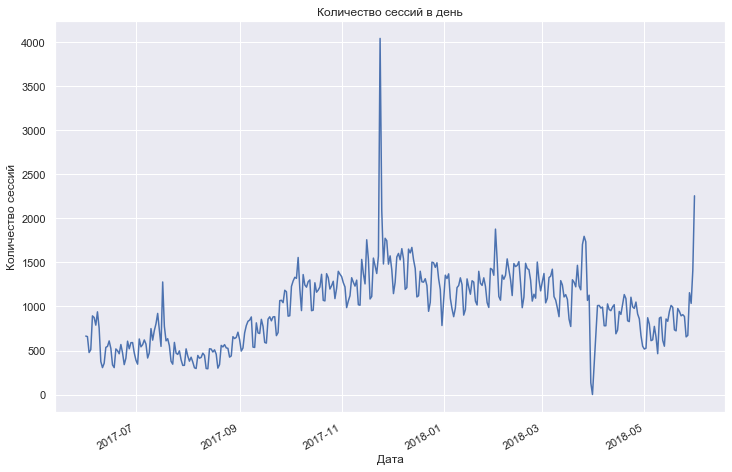

In [14]:
# Сколько cессий в день 
fig, ax = plt.subplots(figsize = (12,8))
#график среднего количества пользователей в день 
# просуммируем количество пользоватлей и количество сессий
sessions_per_user = visits_df.groupby('day').agg({'uid':['count', 'nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions']/sessions_per_user['n_users']
sessions_per_user['n_sessions'].plot(ax = ax, grid = True,  legend=None)
ax.set_title('Количество сессий в день')#  \n в период с {0} по {1}') .format(visits_df['day'].min(), visits_df['day'].max()))
ax.set_ylabel('Количество сессий')
ax.set_xlabel('Дата')
print('Среднее количество сессий в  день  = {0:.2f}'.format(sessions_per_user['n_sessions'].mean()))
print('Среднее количество сессий от одного пользователя в  день  = {0:.2f}'.format(sessions_per_user['sessions_per_user'].mean()))



- Среднее количество сессий в  день  = 987.36, при этом среднее количество сессий от одного пользователя в  день  = 1.08, получается, что количество пользователей и количество сессий в день практически одинаковы и графики их тоже идентичны. Наверное, люди чаще всего заходят на сайт афиши с определенной целью (посмотреть, купить, проверить время) и после выполнения цели не возвращаются в этот день. Информация на сайте не обновляется несколько раз в день, это ведь не новости или социальная сеть.

Среднее количество сессий в день для разных рекламных источников:


source_id
1    1.15
2    1.08
5    1.05
10   1.05
4    1.02
3    1.01
9    1.01
7    1.00
6    1.00
dtype: float64

source_id
4    280.42
3    235.84
5    184.31
2    131.20
1     93.74
9     36.58
10    27.62
7      1.06
6      1.00
dtype: float64

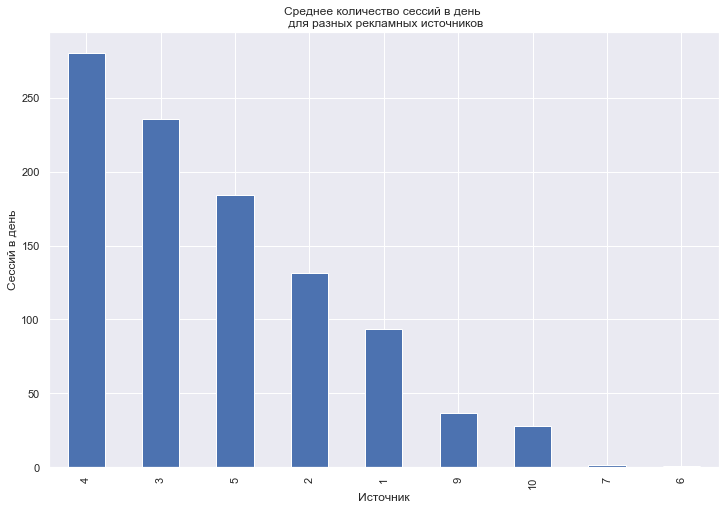

In [15]:

print('Среднее количество сессий в день для разных рекламных источников:')
func_sessions_per_user = lambda x: x.count()/x.nunique()
func_sessions_per_user.__name__ = 'sessions_per_user'

sessions_per_source = visits_df.pivot_table(index = 'day', 
                      columns = 'source_id',
                      values = 'uid', 
                      aggfunc  = ['count', func_sessions_per_user])

# построим графики средних сессий в день из разных источников
fig, ax = plt.subplots(figsize = (12,8))
sessions_per_source['count'].mean().sort_values(ascending = False).plot.bar(grid = True, ax = ax)
ax.set_title('Среднее количество сессий в день \n для разных рекламных источников')#  \n в период с {0} по {1}') .format(visits_df['day'].min(), visits_df['day'].max()))
ax.set_ylabel('Сессий в день')
ax.set_xlabel('Источник')

display(sessions_per_source['sessions_per_user'].mean().sort_values(ascending = False))
display(sessions_per_source['count'].mean().sort_values(ascending = False))
#plt.show()

- Я не стала строить здесь графиков по дням по источникам, потому как при среднем количестве сессий от одного пользователя примерно равным 1, эти графики будут практически идентичны графикам количества пользователей из разных источников. 
- Интересно, что несмотря на то, что в абсолютном значении больше всего сессий происходит из источников 3-4, соотношение сессий к пользователям в них ближе к единице, то есть пользователи редко возвращаются через этот канал в тот же день. 

In [16]:
print('Среднее количество сессий в день для разных устройств:')
visits_df.pivot_table(index = 'day', 
                      columns = 'device',
                      values = 'uid', 
                      aggfunc  = ['count', func_sessions_per_user]).mean()

Среднее количество сессий в день для разных устройств:


                   device 
count              desktop   721.34
                   touch     266.76
sessions_per_user  desktop     1.09
                   touch       1.05
dtype: float64

* среднее количество сессий на пользователя в день чуть выше для компьютеров (1.09), чем для мобильных устройств(1.05). И в общем соотношение с пользователями похожее - сессий с компьютеров в день в 3 раза больше чем с мобильных устройств. 

### 2.1.3. Продолжительность одной сессии

Средняя продолжительность сессии = 643.51 sec
Медиана продолжительности сессии = 300.00 sec
Мода продолжительности сессии = 60.00 sec


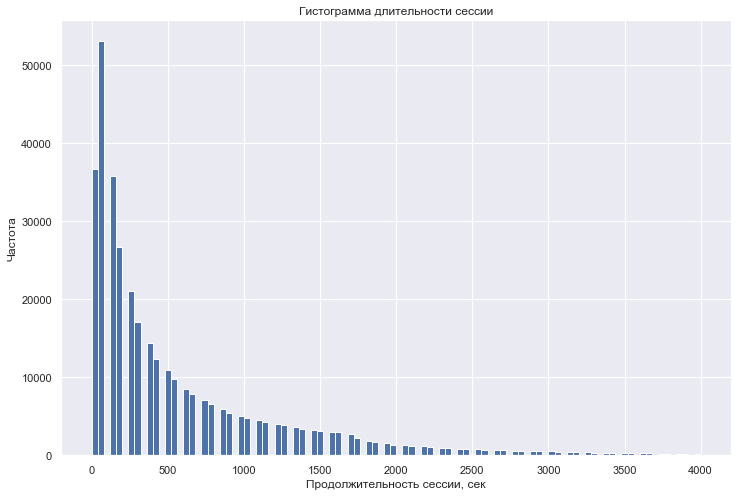

In [17]:
# длительность одной сессии
fig, ax = plt.subplots(figsize = (12,8))
visits_df['session_duration_sec'] = (visits_df['end_ts'] - visits_df['start_ts']).dt.seconds
#visits_df['session_duration_sec'] = (visits_df['end_ts'] - visits_df['start_ts'])/ np.timedelta64(1,'s')
visits_df['session_duration_sec'].hist(bins = 100, range = (0,4000))
ax.set_xlabel('Продолжительность сессии, сек')
ax.set_ylabel('Частота')
ax.set_title('Гистограмма длительности сессии')

print('Средняя продолжительность сессии = {0:.2f} sec'.format(visits_df['session_duration_sec'].mean()))
print('Медиана продолжительности сессии = {0:.2f} sec'.format(visits_df['session_duration_sec'].median()))
print('Мода продолжительности сессии = {0:.2f} sec'.format(visits_df['session_duration_sec'].mode()[0]))

- По диаграмме распределения длительности каждой сессии видно, что это распределение не нормальное и брать среднее арифметическое за среднее значение не справедливо, поэтому за среднее я взяла моду, она равна = 60 сек. 

Средня длительность сессии для разных устройств
Мода продолжительности сессии = 60.00 sec, устройство = desktop
Средняя продолжительность сессии = 703.95 sec, устройство = desktop
Мода продолжительности сессии = 60.00 sec, устройство = touch
Средняя продолжительность сессии = 479.62 sec, устройство = touch


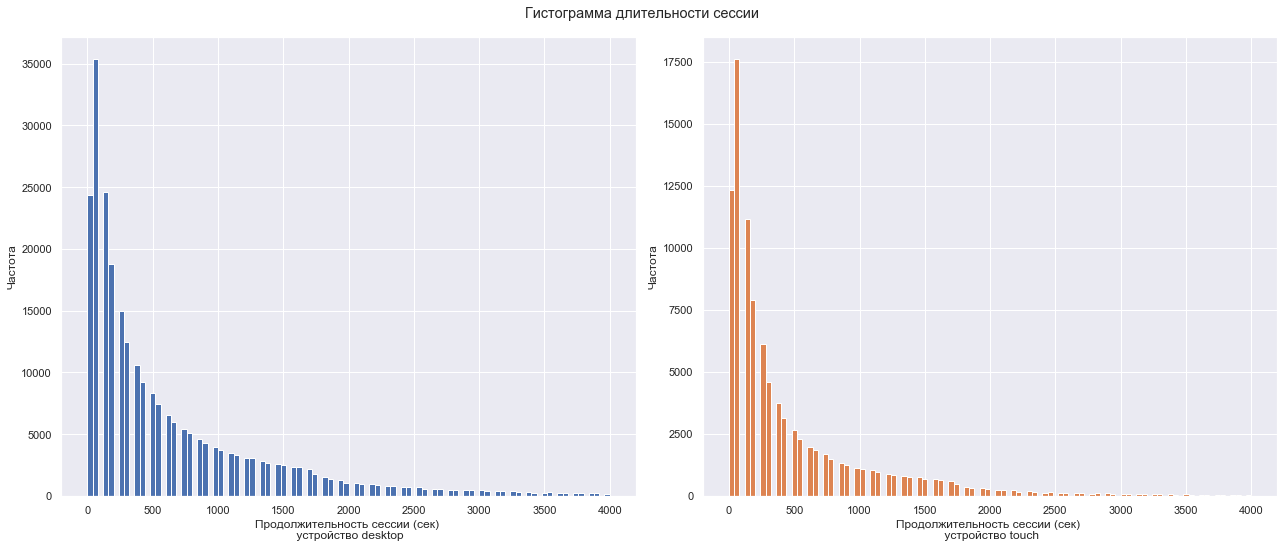

In [18]:
print('Средня длительность сессии для разных устройств')

fig, ax = plt.subplots(1,2, figsize = (18,8))
ax = ax.flatten()
i = 0
for device, device_visits in visits_df.groupby('device'):
  
    print('Мода продолжительности сессии = {0:.2f} sec, устройство = {1}'.format(device_visits['session_duration_sec'].mode()[0], device))
    print('Средняя продолжительность сессии = {0:.2f} sec, устройство = {1}'.format(device_visits['session_duration_sec'].mean(), device))
    device_visits['session_duration_sec'].hist(ax = ax[i], bins = 100, range = (0, 4000), color = 'C'+str(i))
    ax[i].set_xlabel('Продолжительность сессии (сек) \n устройство '+ str(device))
    ax[i].set_ylabel('Частота')
    
    i +=1
fig.suptitle('Гистограмма длительности сессии')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

- Гистограммы длительности сессий похожи для разных устройств, мода для обоих = 60 сек.
- При этом средняя продолжительность сессии на мобильных устройствах в 2 раза меньше, чем на компьютере (479 vs 704 секyнды), видимо на компьютере чаще бывают выбивающиеся долгие сессии, технически на телефоне их сложнее сделать.

Средня длительность сессии для разных рекламных источников:
Мода продолжительности сессии = 60.00 sec, источник = 1
Средняя продолжительность сессии = 1039.36 sec, источник = 1
Мода продолжительности сессии = 60.00 sec, источник = 2
Средняя продолжительность сессии = 844.72 sec, источник = 2
Мода продолжительности сессии = 60.00 sec, источник = 3
Средняя продолжительность сессии = 573.28 sec, источник = 3
Мода продолжительности сессии = 60.00 sec, источник = 4
Средняя продолжительность сессии = 559.84 sec, источник = 4
Мода продолжительности сессии = 60.00 sec, источник = 5
Средняя продолжительность сессии = 526.74 sec, источник = 5
Мода продолжительности сессии = 0.00 sec, источник = 6
Средняя продолжительность сессии = 1370.00 sec, источник = 6
Мода продолжительности сессии = 120.00 sec, источник = 7
Средняя продолжительность сессии = 606.67 sec, источник = 7
Мода продолжительности сессии = 60.00 sec, источник = 9
Средняя продолжительность сессии = 572.54 sec, источник = 9
Мода продо

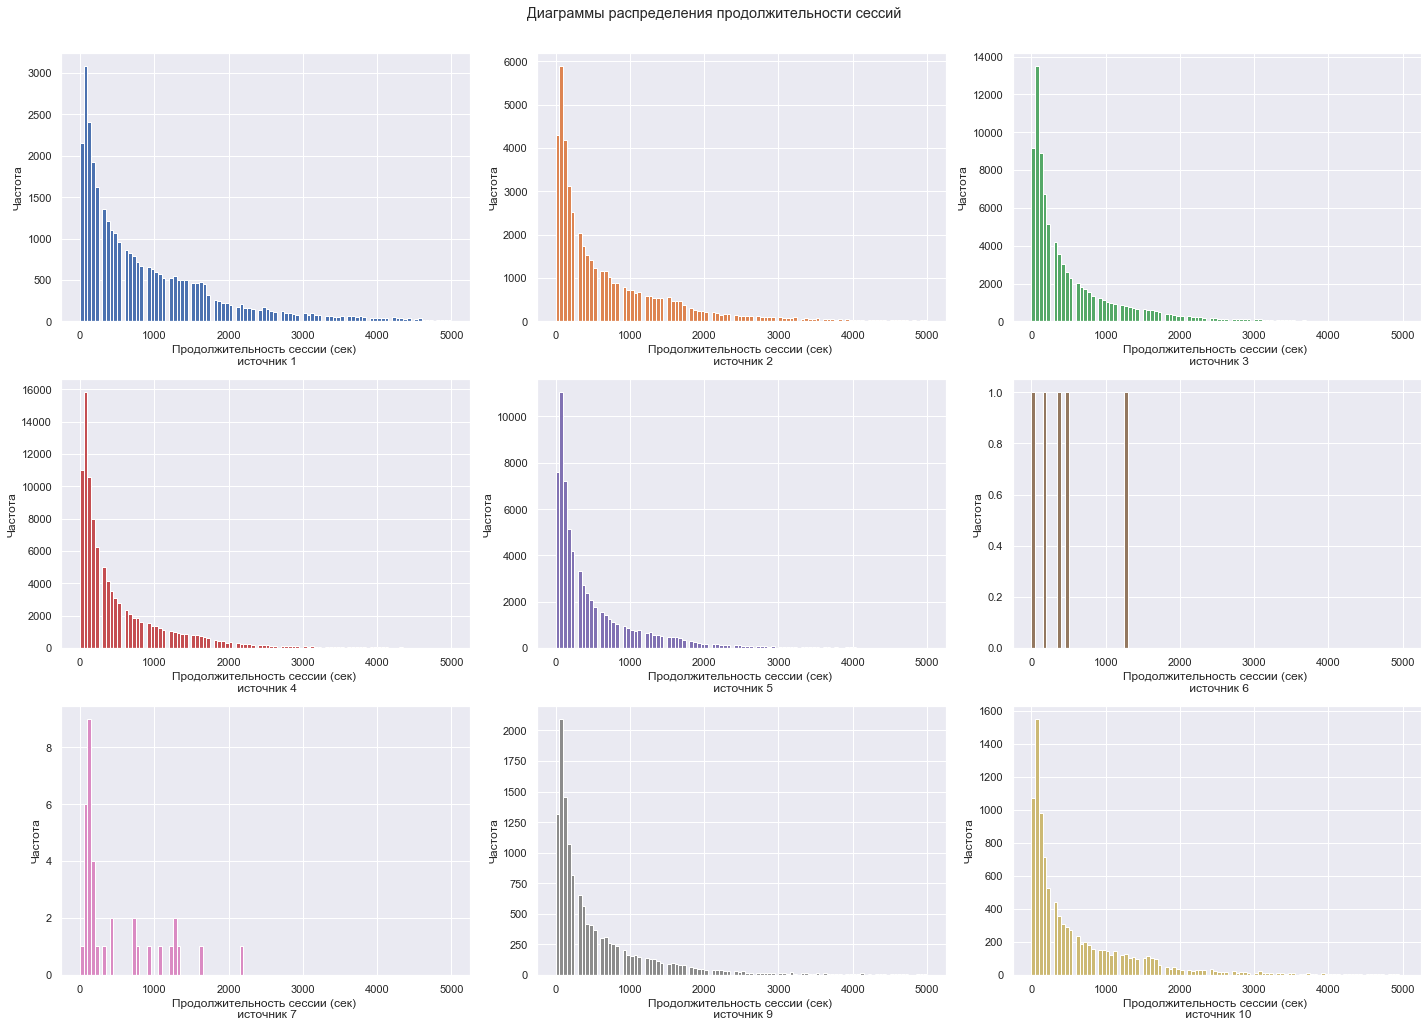

In [19]:
print('Средня длительность сессии для разных рекламных источников:')
fig, ax = plt.subplots(3,3, figsize = (20,15))
ax = ax.flatten()
i = 0
for source, source_visits in visits_df.groupby('source_id'):
    print('Мода продолжительности сессии = {0:.2f} sec, источник = {1}'.format(source_visits['session_duration_sec'].mode()[0], source))
    print('Средняя продолжительность сессии = {0:.2f} sec, источник = {1}'.format(source_visits['session_duration_sec'].mean(), source))
    source_visits['session_duration_sec'].hist(ax = ax[i], bins = 100, range = (0, 5000), color = 'C'+str(i))
    ax[i].set_xlabel('Продолжительность сессии (сек) \n источник '+ str(source))
    ax[i].set_ylabel('Частота')
    
    i +=1
fig.suptitle('Диаграммы распределения продолжительности сессий')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


- распределения длительности сессий похожи для всех источников рекламы, за исключением 6 и 7 источника, но это очень маленькие по количеству сессий источники. 

- Мода продолжительности сессии для всех источников, кроме 6-7, равна 60 сек

### 2.1.4. Как часто люди возвращаются (Retention Rate)

Для расчета Retention Rate разделим пользователей на когорты по месяцу первого посещения:

In [20]:
# найдем для каждого пользователя месяц его первого визита
first_visit = visits_df.groupby('uid')['month'].min()
first_visit.name = 'first_visit_month'

#добавим столбец месяц первого визита в оригинальную таблицу сессий
visits_df = visits_df.join(first_visit, on = 'uid')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 <a list of 12 Text yticklabel objects>)

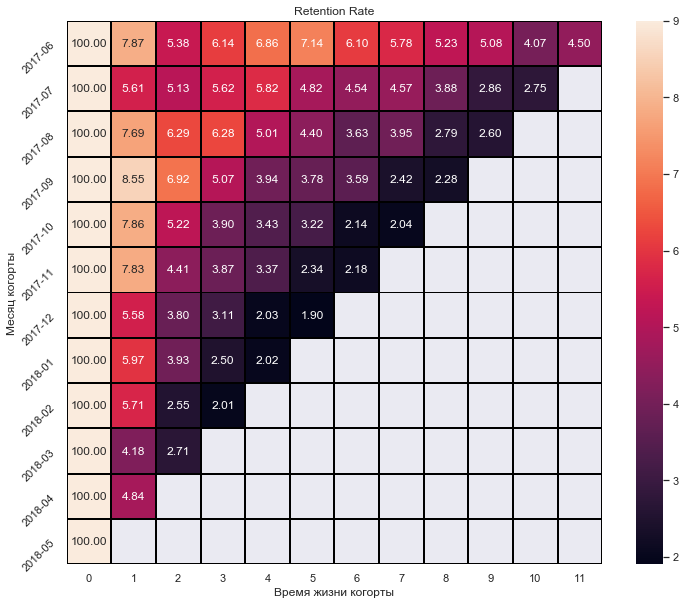

In [21]:
# найдем lifetime когорты для каждой сессии (в месяцах

visits_df['cohort_lifetime'] = (visits_df['month'] - visits_df['first_visit_month'])/np.timedelta64(1,'M')
visits_df['cohort_lifetime'] = visits_df['cohort_lifetime'].round().astype('int')

# разделим всех пользователей на когорты и посчитаем количество уникальных пользователей в каждый Lifetime для каждой когорты
cohorts = visits_df.groupby(['first_visit_month', 'cohort_lifetime'])['uid'].nunique().reset_index()

# количество пользователей в нулевой месяц будет начальным размером когорты
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month', 'uid']]
initial_users_count = initial_users_count.rename(columns = {'uid':'cohort_users'})

# добавим начальный размер когорты в таблицу когорт
cohorts = cohorts.merge(initial_users_count, on = 'first_visit_month') 

# рассчитаем retention rate = (кол-во пользователей в месяц жизни/размер когорты) * 100 % - какая часть возвращается в каждый месяц
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']*100

# собираем все в сводную таблицу
retention_pivot = cohorts.pivot_table(index = 'first_visit_month', 
                                      columns = 'cohort_lifetime', 
                                      values = 'retention', 
                                      aggfunc = 'mean')

# строим тепловую карту
plt.figure(figsize = (12,10))
plt.title('Retention Rate')
retention_pivot.index = retention_pivot.index.to_period("M")
ax = sns.heatmap(retention_pivot, annot = True, fmt = '.2f', linewidths = 1, linecolor = 'black', vmax = 9)
ax.set_xlabel('Время жизни когорты')
ax.set_ylabel('Месяц когорты')
plt.yticks(rotation=45) 

Посчитаем средний Retention Rate для каждого времени жизни когорт:

Средний retention rate для каждого времени жизни когорты:
cohort_lifetime
1    6.52
2    4.63
3    4.28
4    4.06
5    3.94
6    3.70
7    3.75
8    3.55
9    3.52
10   3.41
11   4.50
Name: retention, dtype: float64
Средний retention rate по всем периодам: 4.167273087332413


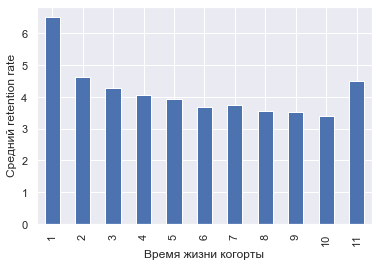

In [22]:
print('Средний retention rate для каждого времени жизни когорты:')
print(cohorts.query('cohort_lifetime > 0').groupby(['cohort_lifetime'])['retention'].mean())
ax = cohorts.query('cohort_lifetime >0').groupby(['cohort_lifetime'])['retention'].mean().plot.bar(grid = True)
ax.set_xlabel('Время жизни когорты')
ax.set_ylabel('Средний retention rate')
print('Средний retention rate по всем периодам:',cohorts.query('cohort_lifetime > 0').groupby(['cohort_lifetime'])['retention'].mean().mean())

Посчитаем Retention Rate для когорт в зависимости от фактического месяца:

Средний retention rate для каждого времени жизни когорты:
month
2017-07-01   7.87
2017-08-01   5.49
2017-09-01   6.32
2017-10-01   6.83
2017-11-01   6.80
2017-12-01   5.68
2018-01-01   4.65
2018-02-01   4.29
2018-03-01   3.98
2018-04-01   2.79
2018-05-01   2.71
Name: retention, dtype: float64


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 <a list of 12 Text yticklabel objects>)

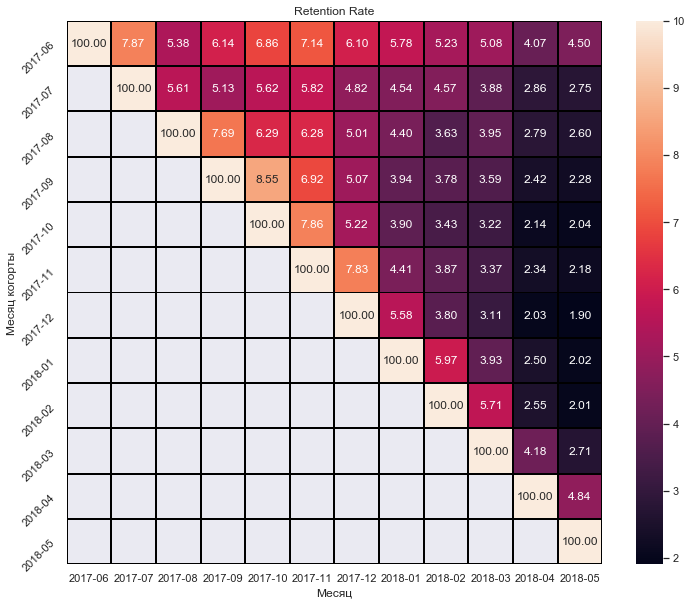

In [23]:
# найдем lifetime когорты для каждой сессии (в месяцах)
visits_df['cohort_lifetime'] = (visits_df['month'] - visits_df['first_visit_month'])/np.timedelta64(1,'M')
visits_df['cohort_lifetime'] = visits_df['cohort_lifetime'].round().astype('int')

# разделим всех пользователей на когорты и посчитаем количество уникальных пользователей в каждый Lifetime для каждой когорты
cohorts = visits_df.groupby(['first_visit_month', 'month'])['uid'].nunique().reset_index()
#display(cohorts.head())
# количество пользователей в нулевой месяц будет начальным размером когорты
initial_users_count = cohorts[cohorts['month'] == cohorts['first_visit_month']][['first_visit_month', 'uid']]
initial_users_count = initial_users_count.rename(columns = {'uid':'cohort_users'})

# добавим начальный размер когорты в таблицу когорт
cohorts = cohorts.merge(initial_users_count, on = 'first_visit_month') 

# рассчитаем retention rate = (кол-во пользователей в месяц жизни/размер когорты) * 100 % - какая часть возвращается в каждый месяц
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']*100
#display(cohorts.head(20))
# собираем все в сводную таблицу
retention_pivot = cohorts.pivot_table(index = 'first_visit_month', 
                                      columns = 'month', 
                                      values = 'retention', 
                                      aggfunc = 'mean')

# строим тепловую карту

plt.figure(figsize = (12,10))
plt.title('Retention Rate')
retention_pivot.index = retention_pivot.index.to_period("M")
retention_pivot.columns = retention_pivot.columns.to_period('M')
#retention_pivot['month'] = retention_pivot['month'].to_period("M")
ax = sns.heatmap(retention_pivot, annot = True, fmt = '.2f', linewidths = 1, linecolor = 'black', vmax = 10)
ax.set_xlabel('Месяц')
ax.set_ylabel('Месяц когорты')

print('Средний retention rate для каждого времени жизни когорты:')
print(cohorts.query('month > first_visit_month').groupby(['month'])['retention'].mean())
plt.yticks(rotation=45) 

* Средний *Retention rate* падает с возрастом когорты с 6.8% до 3.41 % (последнее значение = 4.5 выбивается, но это не среднее, а значение только одной когорты, которая вообще довольно сильно выбивается из общих тенденций, на тепловой карте можно заметить, что первая когорта имеет самые высокие показатели во всех месяцах).
 
* По тепловой карте видно, что с каждой новой когортой *Retention rate* в первый месяц жизни становится все меньше, это плохо, значит все меньше людей хочет возвращаться.  
* При этом новые когорты - это весенние когорты, а у сервиса есть сезонность и если построить и посчитать средний *Retention rate* по фактическим месяцам, а не lifetime, то заметно, что в осенние и зимние месяцы больше людей возвращается, потому что в принципе больше совершают покупок в эти месяцы, а в начале года и весной все меньше и меньше. Думаю, чтобы понять что влияет больше - неудовлетворенность клиентов сервисом в последние месяцы или сезонность, можно сравнить данные за этот год с результатами прошлого года, например. 

Посчитаем средний Retention Rate для каждого времени жизни когорт с делением на устройства:

Средний retention rate для каждого времени жизни когорты для устройства =  touch
cohort_lifetime
1    6.20
2    4.24
3    3.85
4    3.62
5    3.39
6    3.32
7    3.20
8    2.97
9    2.91
10   3.09
11   4.27
Name: retention, dtype: float64
Средний retention rate для каждого времени жизни когорты для устройства =  desktop
cohort_lifetime
1    6.80
2    4.90
3    4.56
4    4.36
5    4.32
6    3.97
7    4.05
8    3.90
9    3.89
10   3.68
11   4.83
Name: retention, dtype: float64


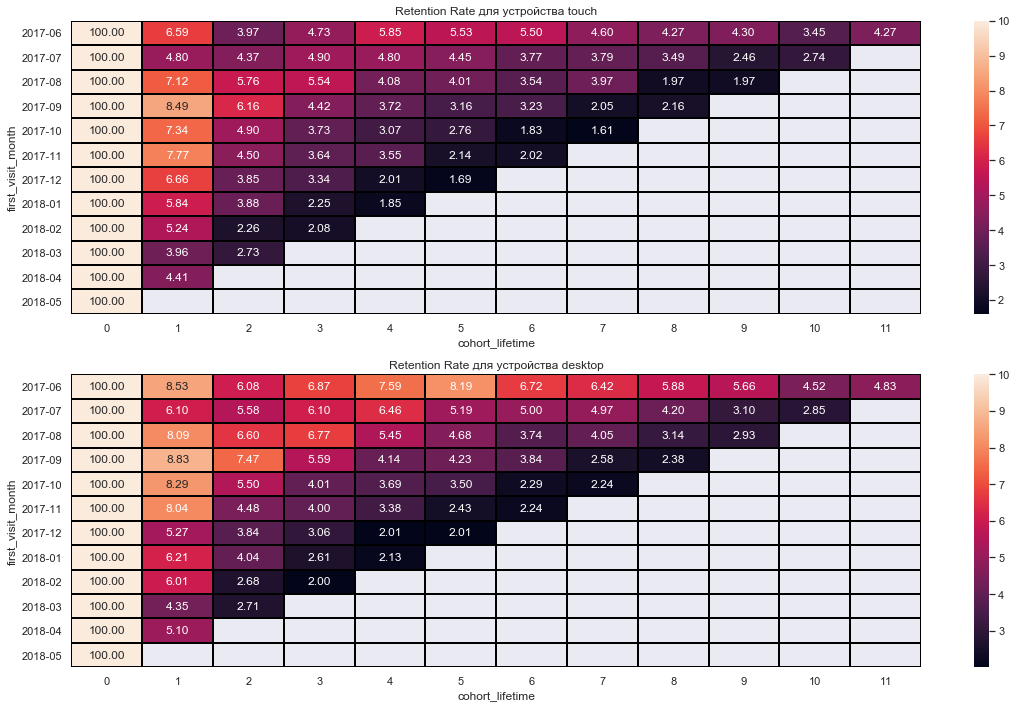

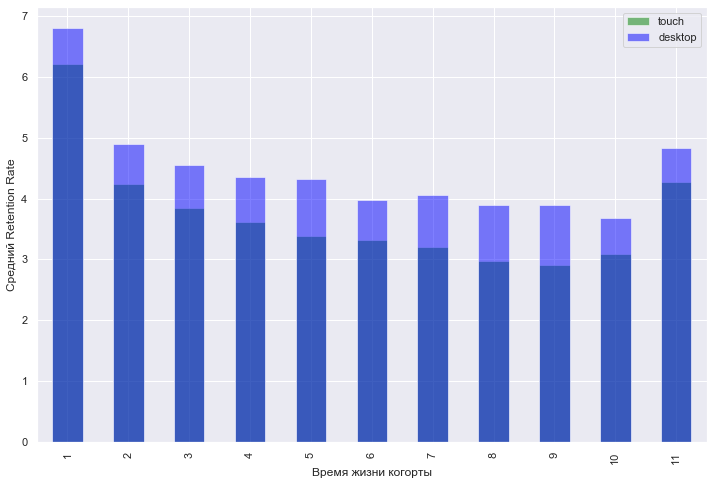

In [24]:
# retention rate по разным устройствам
fig, ax = plt.subplots(2,1, figsize = (16,10))
ax = ax.flatten()

fig2, ax2 = plt.subplots(figsize = (12,8))

# собираем все в сводную таблицу
for device, ax_ , color in zip(visits_df['device'].unique(), ax, ['green','blue']):
    
    # разделим всех пользователей на когорты и посчитаем количество уникальных пользователей в каждый Lifetime для каждой когорты
    cohorts = visits_df.query('device == @device').groupby(['first_visit_month', 'cohort_lifetime'])['uid'].nunique().reset_index()

    # количество пользователей в нулевой месяц будет начальным размером когорты
    initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month', 'uid']]
    initial_users_count = initial_users_count.rename(columns = {'uid':'cohort_users'})
    # добавим начальный размер когорты в таблицу когорт
    cohorts = cohorts.merge(initial_users_count, on = 'first_visit_month') 
    # рассчитаем retention rate = (кол-во пользователей в месяц жизни/размер когорты) * 100 % - какая часть возвращается в каждый месяц
    cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']*100

    # собираем все в сводную таблицу
    retention_pivot = cohorts.pivot_table(index = 'first_visit_month', 
                                          columns = 'cohort_lifetime', 
                                          values = 'retention', 
                                          aggfunc = 'mean')
    # строим тепловую карту    
    ax_.set_title('Retention Rate для устройства '+device)
    ax_.set_xlabel('Время жизни когорты')
    ax_.set_ylabel('Месяц когорты')
    retention_pivot.index = retention_pivot.index.to_period("M")
    sns.heatmap(retention_pivot, annot = True, fmt = '.2f', linewidths = 1, linecolor = 'black', vmax = 10, ax = ax_)
    print('Средний retention rate для каждого времени жизни когорты для устройства = ', device)
    print(cohorts.query('cohort_lifetime > 0').groupby(['cohort_lifetime'])['retention'].mean())
    
    cohorts.query('cohort_lifetime > 0').groupby(['cohort_lifetime'])['retention'].mean().plot.bar(ax = ax2,
                                                                                                   alpha = 0.5,
                                                                                                   label = device,
                                                                                                  color = color)
    
fig.tight_layout()

ax2.set_xlabel('Время жизни когорты')
ax2.set_ylabel('Средний Retention Rate')
ax2.legend()

* По тепловым картам видно, что с источника desktop возвращается больше людей и по графику среднего *Retention Rate* заметно, что процент возвращающихся пользователей на 1-2% выше для пользователей компьютеров.    

## 2.2. Анализ метрик продаж

### 2.2.1. Период между первым визитом и первой покупкой 

In [25]:
#add category is it buyer or just visitor
visits_df.loc[visits_df['uid'].isin(orders_df['uid'].unique()), 'is_buyer'] = 'yes'
visits_df.loc[~visits_df['uid'].isin(orders_df['uid'].unique()), 'is_buyer'] = 'no'

# добавляем порядковый номер сессии
visits_df['session_seq_number'] = visits_df.sort_values(['uid','start_ts'], ascending=[True,True]) \
             .groupby(['uid']) \
             .cumcount() + 1

# оставляем только визиты пользователей, которые делали заказы
buyers_visits = visits_df[visits_df['is_buyer'] == 'yes']

#находим время первого заказа для каждого пользователя 
first_order = orders_df.groupby('uid')['buy_ts'].min()
first_order = first_order.rename('first_order_date') # дата первого заказа
#display(first_order.head())

#добавляем столбец "время первого заказа" в таблицу со всеми визитами-покупателей
buyers_visits = buyers_visits.join(first_order, on = 'uid') 
print('Количество пользователей, сделавших заказ = ',buyers_visits['uid'].nunique())

# добавляем столбец разница между началом текущей сессии и датой первого заказа
buyers_visits['time_to_order'] = (buyers_visits['first_order_date'] - buyers_visits['start_ts'])

first_order_visits = buyers_visits.query('(first_order_date >= start_ts) and (first_order_date <= end_ts)')
print('Количество пользователей, сделавших первый заказ с зафиксированной сессией = ',first_order_visits['uid'].nunique())
#display(buyers_visits[~buyers_visits['uid'].isin(first_order_visits['uid'].unique())].sort_values(by = 'uid')[['uid','start_ts', 'first_order_date', 'end_ts']].head())

display(buyers_visits.head())
display(buyers_visits.info())

Количество пользователей, сделавших заказ =  36523
Количество пользователей, сделавших первый заказ с зафиксированной сессией =  28894


,device,end_ts,source_id,start_ts,uid,year,month,week,day,session_duration_sec,first_visit_month,cohort_lifetime,is_buyer,session_seq_number,first_order_date,time_to_order
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-01,2,yes,2,2018-03-09 20:25:00,-72 days +09:26:00
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-01-01,2017-09-01,2017-08-31,2017-09-03,60,2017-09-01,0,yes,1,2017-09-04 12:46:00,0 days 15:11:00
12,desktop,2018-02-06 15:50:00,4,2018-02-06 15:45:00,8056418121947262981,2018-01-01,2018-02-01,2018-02-01,2018-02-06,300,2017-06-01,8,yes,219,2017-06-25 08:54:00,-227 days +17:09:00
15,touch,2018-02-12 20:30:00,2,2018-02-12 19:24:00,18188358787673499603,2018-01-01,2018-02-01,2018-02-08,2018-02-12,3960,2018-02-01,0,yes,2,2018-02-12 19:48:00,0 days 00:24:00
25,desktop,2017-12-05 10:28:00,4,2017-12-05 10:21:00,2307401184189569202,2017-01-01,2017-12-01,2017-11-30,2017-12-05,420,2017-09-01,3,yes,3,2017-09-27 09:23:00,-70 days +23:02:00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 97394 entries, 3 to 359399
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   device                97394 non-null  object         
 1   end_ts                97394 non-null  datetime64[ns] 
 2   source_id             97394 non-null  int64          
 3   start_ts              97394 non-null  datetime64[ns] 
 4   uid                   97394 non-null  uint64         
 5   year                  97394 non-null  datetime64[ns] 
 6   month                 97394 non-null  datetime64[ns] 
 7   week                  97394 non-null  datetime64[ns] 
 8   day                   97394 non-null  datetime64[ns] 
 9   session_duration_sec  97394 non-null  int64          
 10  first_visit_month     97394 non-null  datetime64[ns] 
 11  cohort_lifetime       97394 non-null  int64          
 12  is_buyer              97394 non-null  object         
 13  

None

- Находим количество сессий до первого заказа(включая заказ) следующим образом:
     - выбираем только сессий, которые произошли до или во время первого заказа (time_to_order >= 0 sec) 
     - группируем таблицу по пользователям и для каждого пользователя находим количество положительных сессий и максимальную разницу между  первым заказом и сессией (это будет время от первого визита до первого заказа)
     
- если добавлять номер сессии и искать в какую по счету сессию был совершен первый заказ, то теряются данные о пользователях, у которых первый заказ не зафиксирован в сессиях, а это примерно 8000 пользователей(5-я часть) 

In [26]:
# выбираем только положительную разницу между сессией и первым заказом, 
# группируем по пользователям
# для каждого находим количество сессий и максимальную разницу во времени
first_orders_stats = buyers_visits.query('time_to_order >= @pd.Timedelta(0) ')\
                    .groupby('uid')\
                    .agg(n_sessions_to_order = ('time_to_order','count'),
                        time_to_order =  ('time_to_order', 'max'))\
                    .reset_index()

#display(first_orders_stats.head())
# display(first_orders_stats['uid'].nunique())

print('Среднее количество сессий до заказа = {0:.2f}'.format(first_orders_stats['n_sessions_to_order'].mean()))
print('Среднее количество сессий до заказа(мода) = ', first_orders_stats['n_sessions_to_order'].mode()[0])
print('Время между первой сессией и первым заказом, статистика:')
display(first_orders_stats['time_to_order'].describe())
print('Среднее время между первой сессией до первым заказом = ', first_orders_stats['time_to_order'].median())

# Распределение количества сессий
#display(first_orders_stats['n_sessions_to_order'].value_counts())
# fig, ax = plt.subplots(figsize = (12,8))
# first_orders_stats['n_sessions_to_order'].value_counts()\
#                                          .head(10)\
#                                          .plot.bar(grid = True, ax = ax)
# ax.set_xlabel('Номер сессии, в которую был сделан первый заказ(top 10)')
# ax.set_ylabel('Количество пользователей')
# plt.show()

fig, ax = plt.subplots(figsize = (12,8))
(first_orders_stats['time_to_order']/np.timedelta64(1,'m')).hist(bins = 60, range = (0,60), ax = ax)
ax.set_xlabel('Разница между первой сессией и первым заказом(в минутах)')
ax.set_ylabel('Количество пользователей')
ax.set_title('Диаграмма распределения разницы между первой сессией и первым заказом')
plt.show()


TypeError: 'VariableNode' object is not callable

* Среднее количество сессий до заказа =  1.53
* Среднее количество сессий до заказа(мода) =  1


- По графику видно, что большая часть пользователей покупает с первой сессии, при этом  разница по времени между началом первой сессии и первым заказом в подавляющем большинстве меньше часа, медиана равна 16 минутам, то есть 50% заказов сделаны за 16 минут с начала первой сессии. Среднее значение времени между первой сессией и заказом (16 дней) сильно подвержено выбросам порядка года разницы между первой сессией и первым заказом. Для дальнейшего анализа, думаю, было бы полезно посмотреть, как пользователи тратят свое время на сайте.

In [ ]:
# количество сессий до заказа для разных устройств

for device in buyers_visits['device'].unique():
    fig, ax = plt.subplots(figsize = (12, 4))
    first_orders_stats = buyers_visits.query('time_to_order >= @pd.Timedelta(0) and device == @device')\
                        .groupby('uid')\
                        .agg(n_sessions_to_order = ('time_to_order','count'),
                            time_to_order =  ('time_to_order', 'max'))\
                        .reset_index()
    print(device)
#     print('Среднее количество сессий до заказа = {0:.2f}'.format(first_orders_stats['n_sessions_to_order'].mean()))
#     print('Среднее количество сессий до заказа(мода) = ', first_orders_stats['n_sessions_to_order'].mode()[0])
    print('Среднее время между первой сессией до первым заказом = ', first_orders_stats['time_to_order'].median())
    
#     # Распределение количества сессий    
#     first_orders_stats['n_sessions_to_order'].value_counts()\
#                                              .head(10)\
#                                              .plot.bar(grid = True, ax = ax)
#     ax[0].set_xlabel('Номер сессии, в которую был сделан первый заказ(top 10)')
#     ax[0].set_ylabel('Количество пользователей')
    
    # гистрограмма временем между первой сессией и первым заказом
    (first_orders_stats['time_to_order']/np.timedelta64(1,'m')).hist(bins = 60, range = (0,60), ax = ax)
    ax.set_xlabel('Разница между первой сессией и первым заказом(в минутах)')
    ax.set_ylabel('Количество пользователей')
    fig.suptitle('Как быстро люди начинают покупать, устройство = '+device)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


**Вывод**

- Графики распределения времени между первой сессией пользователя и первым заказом похожи для разных типов устройств, при этом медиана времени от первой сессии до первого заказа для пользователей компьютера равна 15 минутам, а для пользователей мобильных устройств 47 минутам. Получается, что пользователи компьютеров оформляют заказы быстрее, что, наверное, логично, с компьютера обзор странички лучше, вводить данные удобнее. 
- При таком анализе мы рассматриваем пользователей так, словно они используют либо одно либо другое устройство, а в реальности пользователь может использовать оба, возможно изначально на сайт его привела реклама на мобильном устройстве, но оформлять заказы он предпочитает на компьютере.

### 2.2.2. Сколько покупок совершают пользователи за период

Разделим покупателей на когорты по месяцу первого заказа.

In [ ]:
# Делим покупателей на когорты
#находим время первого заказа для каждого пользователя 
first_order = orders_df.groupby('uid')['month'].min()
first_order.name = 'first_order_month' # месяц первого заказа
orders_df = orders_df.join(first_order, on = 'uid')


In [ ]:
#рассчитываем время жизни когорты (lifetime)
orders_df['cohort_lifetime'] = (orders_df['month'] - orders_df['first_order_month'])/np.timedelta64(1,'M')
orders_df['cohort_lifetime'] = orders_df['cohort_lifetime'].round().astype('int')
    
# делим пользователей-покупателей на когорты и находим для каждого lifetime когорты:
#  количество покупателей
#  количество заказов
#  выручку

orders_cohorts = orders_df.groupby(['first_order_month', 'cohort_lifetime'])\
                   .agg( 
                    n_users = ('uid','nunique'),
                    n_orders = ('uid','count'),
                    revenue = ('revenue','sum'))\
                    .reset_index()

# определим размер когорты(количество покупателей в нулевой месяц жизни)
initial_users_count = orders_cohorts[orders_cohorts['cohort_lifetime'] == 0][['first_order_month', 'n_users']]
initial_users_count = initial_users_count.rename(columns = {'n_users':'cohort_users'})

# добавляем размер когорты в таблицу когорт
orders_cohorts = orders_cohorts.merge(initial_users_count, on = 'first_order_month')

# подсчитаем общее количество заказов в каждое время жизни когорты (с нулевого lifetime по текущий)
orders_cohorts['orders_cumsum'] = orders_cohorts.sort_values(['first_order_month', 'cohort_lifetime'])\
                                .groupby('first_order_month')['n_orders']\
                                .cumsum()
#display(orders_cohorts.groupby('first_order_month')['n_orders'].sum())
# рассчитываем количество заказов на одного пользователя когорты на каждом периоде жизни
orders_cohorts['orders_per_cohort'] = orders_cohorts['orders_cumsum']/orders_cohorts['cohort_users']

# средний чек в когорте в каждое  Lifetime
orders_cohorts['revenue_per_user'] = orders_cohorts['revenue']/orders_cohorts['n_users']
#display(orders_cohorts.head())
display('Размеры когорт:')
display(orders_cohorts.groupby('first_order_month')['cohort_users'].mean()) 

In [ ]:
#сводная таблица количество заказов на пользователя за все время жизни когорты

orders_pivot = orders_cohorts.pivot_table(index = 'first_order_month', 
                                    columns = 'cohort_lifetime',
                                    values = 'orders_per_cohort', 
                                    aggfunc = 'sum')
plt.figure(figsize = (12,10))
plt.title('Количество заказов на пользователя')
orders_pivot.index = orders_pivot.index.to_period("M")
ax = sns.heatmap(orders_pivot, annot = True, fmt = '.2f', linewidths = 1, linecolor = 'black') 
ax.set_xlabel('Время жизни когорты')
ax.set_ylabel('Месяц когорты')
plt.yticks(rotation=45) 

In [ ]:
# Среднее по когортам количество заказов за период 6 месяцев
display(orders_cohorts[orders_cohorts['cohort_lifetime'] == 5][['first_order_month','orders_per_cohort']]) 
print ('Среднее по когортам количество заказов за период 6 месяцев = {0:.2f}'.format(
    orders_cohorts[orders_cohorts['cohort_lifetime'] == 5][['orders_per_cohort']].mean()[0]))

**Вывод**

- за год получилось 12 когорт, размеры которых коррелируют с тендециями по количеству пользователей в разные месяцы  - максимальный размер у октябрьской, ноябрьской и декабрьской когорты (больше 4000), минимальный у июльской и августовcкой (меньше 2000 ).

- По тепловой карте общего количества покупок на пользователя видно, что покупают не так часто - за год этот показатель у первой когорты перешагнул за 2 заказа на пользователя, а у ближайших лишь приблизился к 1.5 заказам на пользователя за период 10-11 месяцев. Первая когорта сильно выделяется от остальных более высоким количеством заказов во все периоды

- в среднем за 6 месяцев, каждый пользоватеь совершает 1.43 заказа, то есть примерно половина пользователей совершает 1 заказ, а вторая 2 заказа. Не заметно какой-то тенденции к уменьшению количества заказов на пользователя с каждой новой когортой, за исключеием первой выделяющейся когорты, это значение примерно равно 1.4 для всех когорт. 

### 2.2.3. Средний чек пользователя

In [ ]:
#средний счет для одного пользователя в когортах
avg_order_pivot = orders_cohorts.pivot_table(index = 'first_order_month', 
                                    columns = 'cohort_lifetime',
                                    values = 'revenue_per_user', 
                                    aggfunc = 'mean')

#display(avg_order_pivot.fillna(''))

plt.figure(figsize = (12,10))
plt.title('Средний счет пользователя для каждого периода жизни когорты')
avg_order_pivot.index = avg_order_pivot.index.to_period("M")
ax = sns.heatmap(avg_order_pivot, annot = True, fmt = '.2f', linewidths = 1, linecolor = 'black', vmax = 50)
ax.set_xlabel('Время жизни когорты')
ax.set_ylabel('Месяц когорты')
plt.yticks(rotation=45) 

**Вывод**

- по тепловой карте видно,  выделяются 3 когорты (июнь, сентябрь и декабрь) с наибольшими средними чеками.

- есть выделяющиеся значения(например, 138 в сентбярьской когорте),  на которые влияют необычно большие заказы (возможно кто-то покупает сразу большую партию билетов на школу/организацию и тп)

- нет какой-то закономерности, что средний чек растет или падает с каждой новой когортой или растет внутри когорты (например, что покупатели тратят тем больше, чем дольше они с сервисом)

Рассматрим общий средний чек в день, неделю, месяц.

In [ ]:
# группируем заказы по дням
    
translate_period = {'day': 'день',
                  'week': 'неделю',
                  'month': 'месяц'
                    }
# Срений чек в разные периоды

fig, ax = plt.subplots(3,1, figsize = (12,9))
ax = ax.flatten()
for period, ax_ in zip(['day', 'week', 'month'], ax):  
    
    # сводная таблица
    period_orders = orders_df.groupby(period)\
                       .agg(                   
                        n_orders = ('uid','count'),
                        revenue = ('revenue','sum'))\
                        .reset_index()
    
    period_orders['revenue_per_order'] = period_orders['revenue']/period_orders['n_orders']

    #график среднего чека 
    period_orders.\
            plot(x = period, y = 'revenue_per_order', ax = ax_, color = 'green', grid = True,  legend=None)
    ax_.set_title(f'Средний чек в {translate_period[period]}')
    ax_.set_ylabel('Средний чек, руб')
    ax_.set_xlabel('Дата')
    print('Средний чек в {1} = {0:.2f}'.format(period_orders['revenue_per_order'].mean(),translate_period[period]))
    print('Максимальный средний чек {1:.2f} и минимальный средний чек =  {0:.2f}'.format(
        period_orders['revenue_per_order'].min(), period_orders['revenue_per_order'].max()))

fig.tight_layout()


# # группируем заказы по дням
    
# translate_period = {'day': 'день',
#                   'week': 'неделя',
#                   'month': 'месяц'
#                     }
# # Срений чек в разные периоды

# fig, ax = plt.subplots(figsize = (12,4))
# for period in ['day', 'week', 'month']:  
    
#     # сводная таблица
#     period_orders = orders_df.groupby(period)\
#                        .agg(                   
#                         n_orders = ('uid','count'),
#                         revenue = ('revenue','sum'))\
#                         .reset_index()
    
#     period_orders['revenue_per_order'] = period_orders['revenue']/period_orders['n_orders']

#     #график среднего чека 
#     period_orders.\
#             plot(x = period, y = 'revenue_per_order', ax = ax, grid = True, label = translate_period[period])
#      #print('Средний чек в {1} = {0:.2f}'.format(period_orders['revenue_per_order'].mean(),translate_period[period]))

# ax.set_title('Средний чек в разные периоды')
# ax.set_ylabel('Средний чек, руб')
# ax.set_xlabel('Дата') 
# ax.legend()

- Средний чек в день, неделю и месяц похожи:
    - Средний чек в день = 4.94
    - Средний чек в неделю = 5.00
    - Средний чек в месяц = 4.84
    
- По графику среднего чека по дням заметны большие пики в середине-конце декабря, в начале марта и в апреле/мае, наверное, они связаны с большим количеством мероприятий в эти дни(Новый год и каникулы, праздники?). Сам график шумный, наверное с чуть большим чеком в районе выходных, и меньшим в будни. 
- Графики по неделям и месяц похожи на график по дням пропущенный один или два раза через фильтр нижних частот, они намного менее шумные. Если посмотреть на эти графики отдельно, то заметны похожие пики в сентябре, декабре,  весной, но размах пиков уже намного меньше (это видно на общем графике):

  - Максимальный средний чек 29.13 и минимальный средний чек =  1.95 в день
  - Максимальный средний чек 7.56 и минимальный средний чек =  2.84 в неделю
  - Максимальный средний чек 5.85 и минимальный средний чек =  3.42 в месяц
 

### 2.2.3.  Life Time Value (LTV) покупателей  

Посчитаем LTV по ранее выделенным когортам:

In [ ]:
margin_rate = 1     #так как у нас нет данных о margin_rate, выберем сами маржинальность равной 1
# валовая прибыль
orders_cohorts['gp'] = orders_cohorts['revenue']*margin_rate 

orders_cohorts['ltv'] = orders_cohorts['gp']/orders_cohorts['cohort_users'] 
#display(orders_cohorts.head())

#просуммируем LTV для когорты на кажлый периол жизни когорты
ltv_pivot = orders_cohorts.pivot_table(index = 'first_order_month', 
                                    columns = 'cohort_lifetime',
                                    values = 'ltv', 
                                    aggfunc = 'mean')\
                            .cumsum(axis=1).round(2)

#display(ltv_pivot.fillna(''))

#построим тепловую карту
plt.figure(figsize = (12,10))
plt.title('LTV пользователя в каждый период жизни когорты')
ltv_pivot.index = ltv_pivot.index.to_period("M")
ax = sns.heatmap(ltv_pivot, annot = True, fmt = '.2f', linewidths = 1, linecolor = 'black') #, v
ax.set_xlabel('Время жизни когорты')
ax.set_ylabel('Месяц когорты')
plt.yticks(rotation = 45)
plt.show()

#print('Среднее по когортам LTV для разных периодов:', ltv_pivot.mean(axis=0))
print('Среднее по когортам LTV за 6 месяцев: {0:.2f}'.format(ltv_pivot.mean(axis=0)[5]))

#посмотроим среднее по когортам LTV для разных периодов
plt.figure(figsize = (12,8))
ax = ltv_pivot.mean(axis=0).plot(grid = True)
ax.set_xlabel('Время жизни когорты')
ax.set_ylabel('Среднее по когортам LTV')
plt.show()

**Вывод**

- Июньская и сентябрьская когорты имеют максимальные LTV.
- Среднее по когортам LTV за 6 месяцев: 7.97 рублей с пользователя. 
- По тепловой карте видно, что когорты, начиная с январской получают более низкий LTV по сравнению с более ранними когортами за такой же период жизни

## 2.3. Анализ метрик затрат на маркетинг
​
### 2.3.1. Затраты на рекламу за весь период, на каждый источник / по времени

In [ ]:
costs_by_source = costs_df.groupby('source_id')['costs']\
        .sum()
sns.set()
plt.figure(figsize = (12,8))
ax = costs_by_source\
        .sort_values(ascending = False)\
        .plot.bar(grid = True)
ax.set_ylabel('Потрачено денег на маркетинг')
ax.set_xlabel('Источник')
ax.set_title('Расходы на маркетинг в зависимости от источника')
print('Всего потрачено = {0:.2f}'.format(costs_by_source.sum()))

print('Затраты по источникам в %')
display(costs_by_source.sort_values(ascending = False))
print('Затраты по источникам в %')
display((costs_by_source/costs_by_source.sum()*100).sort_values(ascending = False))

**Вывод**

* Всего за год на маркетинг потратили 329131.62 руб. Затраты по источникам:

    - 3  =   141321.63
    - 4   =   61073.60
    - 5    =  51757.10
    - 2   =   42806.04
    - 1   =   20833.27
    - 10  =    5822.49
    - 9   =    5517.49
* Большая часть маркетингового бюджета тратится на 4 источника(3,4,5,2), на остальные 3 приходится меньше 10 %. Больше всего было потрачено на 3-й источник (42%), на втором месте 4-й (18.5 %), 5-й - 15%,  2-й - 13%. При этом количество пользователей пришедших из 4го источника даже больше, чем из 3-го (результаты первого пункта исследования - 4-й источник  в месяц 7765.67 , а  3-й  6758.83 человек в месяц.
* 6 и 7-го источника вообще нет в затратах, однако некоторые люди приходят на сайт через них.

In [ ]:
#изменение расходов на маркетинг по месяцам для разных источников

monthly_costs = costs_df.groupby(['source_id','month'])['costs'].sum().reset_index()
#display(monthly_costs.head(10))
fig, ax = plt.subplots(figsize = (12,8))
for source in costs_df['source_id'].unique():
    monthly_costs.query('source_id == @source').plot( x ='month', y = 'costs', ax = ax, label = 'источник ='+ str(source))
# общие расходы в месяц    
costs_df.groupby(['month'])['costs'].sum().reset_index().plot(x ='month', y = 'costs', ax = ax, label = "всего")
ax.grid(True)
ax.set_ylabel('Затраты, руб.')
ax.set_xlabel('Дата')
ax.set_title('Затраты на разные источники рекламы за год')

In [ ]:
#изменение расходов на маркетинг по месяцам для разных источников в долях

monthly_costs = costs_df.pivot_table(index ='month', columns = 'source_id', values = 'costs', aggfunc = 'sum')
monthly_costs = monthly_costs.div(monthly_costs.sum(1), 0)*100
#display(monthly_costs.head(10))
fig, ax = plt.subplots(figsize = (12,8))

monthly_costs.index = monthly_costs.index.to_period("M")
monthly_costs.plot.bar(stacked = True, grid = True, ax = ax)
ax.legend(bbox_to_anchor=(1.1, 1))
ax.set_title('Расходы на маркетинг по месяцам')
ax.set_xlabel('Месяц')
ax.set_ylabel('Потрачено, руб.')


**Вывод**

* По графику месяц видно, что затраты на рекламу сильно растут начиная с сентября, наиболее дорогие по рекламе месяцы октябрь-ноябрь, далее постпенно затраты уменьшаются, весно и летом минимальны. 

* Графики затрат по источникам в приниципе повторяют общую тенденцию, но видно, что в основном расходы зимой растут из-за того, что растут расходы на рекламу в 3-м источнике. 

* На графике с долями каждого источника в бюджете на рекламу, видно, что пропорция, с которой распределены затраты между источниками, примерно одинаковая каждый месяц.  Заметно лишь, что у 4го источника почему-то есть большой спад в финансировании в ноябре за счет больших затрат на 3й и 4-й источник, интересно узнать у маркетинга, с чем это связано. 

### 2.3.2. Сколько стоило привлечение одного покупателя из каждого источника?

In [ ]:
#находим источник первой сессии для каждого пользователя и сохраняем  источник 
first_session_source = visits_df[visits_df['session_seq_number'] == 1][['uid', 'source_id']]
#добавляем источник первой сессии для каждого пользователя в таблицу заказов
orders_df = orders_df.merge(first_session_source, on = 'uid')
#display(orders_df.tail())

In [ ]:
#рассходы на разные источники рекламы по месяцам
monthly_costs = costs_df.groupby(['month', 'source_id'])['costs'].sum().reset_index()

# посчитаем количество пользователей из каждого источника рекламы по когортам
cac_by_source = orders_df.groupby(['first_order_month', 'source_id'])\
                                .agg(cohort_size = ('uid', 'nunique'))\
                                .reset_index()

# добавляем расходы на рекламу по месяцам
cac_by_source = pd.merge(cac_by_source, monthly_costs, left_on = ['first_order_month','source_id'], right_on = ['month','source_id'])
#
cac_by_source['cac'] = cac_by_source['costs']/cac_by_source['cohort_size']

#создадим сводную таблицу для сас по источникам
report = cac_by_source.pivot_table(index = 'first_order_month', columns = 'source_id', values = 'cac')
#display(cac_by_source.fillna(''))

fig, ax = plt.subplots(figsize = (12,8))
report.plot(ax = ax) #x ='first_order_month', y = 'cac', ax = ax, grid = True)
ax.set_xlabel('Месяц')
ax.set_ylabel('cac, руб')
ax.set_title('Cac для разных источников в течение года')
ax.legend(bbox_to_anchor=(1.1, 1))

#суммарный сас за весь год
total_cac = cac_by_source.groupby('source_id').agg(total_users = ('cohort_size', 'sum'),
                                            total_costs = ('costs','sum'))\
                                        .reset_index()
total_cac['cac'] = total_cac['total_costs']/total_cac['total_users']
display(total_cac[['source_id','total_users', 'cac']].sort_values(by = 'cac', ascending = False))


**Вывод**
- Стоимость привлечения одного покупателя по источникам рекламы:
    - 3 = 13.49
    - 2	= 12.21
    - 5	= 7.47
    - 1	= 7.19
    - 4	= 5.93
    - 9	= 5.07
    - 10 = 4.38
- Самыми дорогими для привлечения были пользователи из источников 3 и 2 (сас очень большие (13 и 12), почти в 2 раза больше сас для следующего источника(5)), самыми дешевыми - 4,9,10, при этом источник 4 второй по количеству привлеченных пользователей. 
- По графику видно, что для большинства источников сас имеет пик-максимум в июле-августе, когда у сервиса низкий сезон, в течение остального года сас относительно стабилен. Возможно максимум объяняется тем, что рекламные компании нужно запускать заранее.


### 2.3.2. Насколько окупились расходы? (ROMI)

In [ ]:
def create_source_cohort(orders_df, monthly_costs, source):
    '''
    функция возвращает сгуппированные по когортам данные orders_df
    для заданного источника рекламы source
    и рассчитывает сас и romi 
    '''
    
    orders_by_source = orders_df.query('source_id == @source')

    # найдем размеры когорт
    cohort_sizes = orders_by_source.groupby('first_order_month')\
                                    .agg({'uid': 'nunique'})\
                                    .reset_index()
    cohort_sizes.columns = ['first_order_month', 'n_buyers']
    
    # cгруппируем когорты и найдем выручку за каждый месяц
    cohorts = orders_by_source.groupby(['first_order_month','cohort_lifetime'])\
                            .agg({'revenue': 'sum'})\
                            .reset_index()
    #display(cohorts.head()) 
    
    # Добавим размер когорты
    report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
    #display(report.head())

    margin_rate = 1 # примем маржинальность равной 1 

    report['gp'] = report['revenue'] * margin_rate #валовая прибыль
    report['ltv'] = report['gp'] / report['n_buyers'] #ltv
    #display(report.head())
    
    costs = monthly_costs[source]    
    #добавим информацию о затратах на рекламу из этого источника по месяцам
    report_new = pd.merge(report, 
                          costs, 
                          left_on='first_order_month',
                          right_on='month')    
    report_new = report_new.rename(columns = {source:'costs'}, 
                                   errors="raise")
    #display(report_new.head())
    
    #рассчитаем сас
    report_new['cac'] = report_new['costs'] / report_new['n_buyers'] 
    report_new['romi'] = report_new['ltv'] / report_new['cac'] #рассчитаем romi 
    
    return report_new

In [ ]:
# Расходы по месяцам
monthly_costs = costs_df.pivot_table(index ='month', 
                                     columns = 'source_id', 
                                     values = 'costs', 
                                     aggfunc = 'sum')

fig1, ax1 = plt.subplots(figsize = (12,8))  # График для среднего romi
fig, ax = plt.subplots(4,2, figsize = (18,18)) # График для тепловых карт
ax = ax.flatten()

# Для каждого источника рекламы делим людей на когорты и находим сас и romi

for source, ax_ in zip(costs_df['source_id'].unique(), ax):    
        
    source_cohort = create_source_cohort(orders_df, monthly_costs, source)
    # print(source)
    # display(cohort.head())
    
    #сводная таблица с romi по когортам
    romi_by_source = source_cohort.pivot_table(
            index='first_order_month', 
            columns='cohort_lifetime', 
            values='romi', 
            aggfunc='mean').cumsum(axis=1).round(2)
    
    ax_.set_title('ROMI для источника = '+ str(source))
    romi_by_source.index = romi_by_source.index.to_period("M")
    sns.heatmap(romi_by_source, annot = True, fmt = '.2f', linewidths = 1, linecolor = 'black', ax = ax_) #, vmax = 1)
    ax_.set_xlabel('Время жизни когорты')
    ax_.set_ylabel('Месяц когорты')
    
    #строим romi по времени жизни когорты для источника    
    romi_by_source.mean(axis=0).plot(ax = ax1, grid = True, label = "источник =" + str(source))

ax1.axhline(y = 1, color = 'black', linestyle = '--', label = 'ROMI = 1')
ax1.legend()    
fig.tight_layout()

**Вывод**

- По общему графику среднего ROMI по времени жизни когорты для каждого источника рекламы самым окупаемым выглядят источники 1, 5, 9

- 1й источник очень быстро окупался в ранних когортах(за 1,2 месяца), однако, начиная с декабря, этот источник стал хуже окупаться. Это видно по тепловой карте
- Самая низкая окупаемость у источника 3, он никогда не достигает единицы (максимум 0.54). Это означает, что все огромные расходы на источник 3 не окупились даже наполовину, кажется, маркетинг вкладывал деньги не в тот источник. 

- Стабильно хорошо окупаемым выглядит источник 4, он окупается примерно за 10 месяцев, но при этом это второй по количеству пользователей источник.

In [ ]:
#суммарный romi за весь год
romi_report = orders_df.groupby(['source_id'])\
                            .agg(total_users = ('uid', 'nunique'),
                                 total_revenue = ('revenue', 'sum'))\
                            .reset_index()
romi_report['ltv'] = romi_report['total_revenue']/romi_report['total_users']
#display(romi_report)
romi_report = romi_report.merge(total_cac[['source_id','cac']], on = 'source_id')
#display(romi_report)
romi_report['romi'] = romi_report['ltv']/romi_report['cac']
display(romi_report.sort_values(by = 'romi'))

**Вывод**

- По общей окупаемости за год окупились (romi > 1) только источники 1,2, 9, 5. Источник 4 почти окупился(romi = 0.94), самый плохо окупившийся источник - 3 (0.39)

# Общий вывод

Целью работы было помочь маркетологам оптимизировать маркетинговые затраты, используя данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года.

Был проведен следующий анализ:

- Для **продукта**:
    - Среднее количество пользователей в день (DAU) = 908. У сервиса есть сезонность - летом среднее количество пользователей меньше среднего (колеблется около 500), а зимой выше(колеблется в районе 1000), есть ярко выраженный пик в середине-конце декабря.
        - В среднем в 3 раза чаще пользователи заходят в сервис через компьютер(desktop):
             - Среднее количество пользователей в день, устройство touch = 253
             - Среднее количество пользователей в день, устройство desktop = 659 
             
  - Общее среднее количество пользователей в неделю (WAU) = 5724.42,  Общее среднее количество пользователей в месяц (MAU) = 23228.42.  По устройствам соотношение сохраняется таким же, как в день.
  
  - Больше всего пользователей приходит из 4 и 3-го источника рекламы (в месяц 29 и 25 % соответственно), третий по величине источник номер 5 (19%), меньше всего из 6-7 (несколько человек или вообще ни одного в месяц - либо это очень непопулярный источник, либо данные неполные).
  

   - Среднее количество сессий в  день  = 987.36, при этом среднее количество сессий от одного пользователя в  день  = 1.08. Среднее количество сессий на пользователя в день чуть выше для компьютеров (1.09), чем для мобильных устройств(1.05).
   
   - Средняя продолжительность одной сессии = 60 сек, независимо от источника и устройства
    
   - Средний *Retention rate* (количество вовращающихся пользователей) падает с возрастом когорты с 6.8% до 3.41 %.  С каждой новой когортой *Retention rate* в первый месяц жизни становится все меньше, значит все меньше людей хочет возвращаться.  Среди пользователей компьютера в среднем возвращается на 1-2% больше людей, чем у пользователей мобильных устройств.

- Для **продаж**:
    * Большая часть пользователей покупает с первой сессии, при этом  разница по времени между началом первой сессии и первым заказом в подавляющем большинстве меньше часа, медиана равна 16 минутам, то есть 50% заказов сделаны за 16 минут с начала первой сессии. Среднее количество сессий до заказа одинаковое для компьютеров и мобильных устройств =  1 и средняя величина тоже почти одинаковые 1.45 и 1.49 сессий, но при этом пользователи компьютера покупают быстрее(медиана времени от первой сессии до первого заказа для пользователей компьютера равна 15 минутам, а для пользователей мобильных устройств 47 минутам)
    
    * Покупают не очень часто - в среднем за 6 месяцев каждый пользоватеь совершает 1.43 заказа, то есть примерно половина пользователей совершает 1 заказ, а вторая 2 заказа. Не заметно какой-то тенденции к уменьшению количества заказов на пользователя с каждой новой когортой.
    
    * Средний чек в день, неделю и месяц похожи:
        - Средний чек в день = 4.94
        - Средний чек в неделю = 5.00
        - Средний чек в месяц = 4.84
     * Не выявлено какой-то зависимости среднего чека от времени жизни когорты
    
    * Среднее по когортам LTV за 6 месяцев: 7.97 рублей с пользователя. Когорты, начиная с январской получают более низкий LTV по сравнению с более ранними когортами за такой же период жизни - это либо из-за сезонности, либо из-за каких-то внутренних изменений сервиса, которые заставляют пользователей меньше покупать.
   
- Для **маркетинга**:
   
     * Всего за год на маркетинг потратили 329131.62 руб.  Большая часть маркетингового бюджета тратится на 4 источника(3,4,5,2), на остальные 3 приходится меньше 10 %. Больше всего было потрачено на 3-й источник (42%), на втором месте 4-й (18.5 %), 5-й - 15%,  2-й - 13%. Затраты на рекламу сильно растут начиная с сентября, наиболее дорогие по рекламе месяцы октябрь-ноябрь, далее постепенно затраты уменьшаются, весной и летом минимальны. Пропорция, с которой распределены затраты между источниками, примерно одинаковая каждый месяц.  
     * Стоимость привлечения одного покупателя по источникам рекламы:
        - 3 = 13.49
        - 2	= 12.21
        - 5	= 7.47
        - 1	= 7.19
        - 4	= 5.93
        - 9	= 5.07
        - 10 = 4.38
        Самыми дорогими для привлечения были пользователи из источников 3 и 2 (сас очень большие (13 и 12), почти в 2 раза больше сас для следующего источника(5)), самыми дешевыми - 4,9,10.

     * По общей окупаемости за год окупились(romi > 1) только источники 1,2, 9, 5. Источник 4 почти окупился(romi = 0.94), самый плохо окупившийся источник - 3 (0.39)
        
  
**Вывод-рекомендация:**

 - Мне кажется, что стоит увеличить затраты на источники  1, 5, 9 - их объем сейчас невелик, а при этом окупаемость высокая(cac 7.19, 7.47 и 5.07 соответсвенно). У второго источника слишком высокий сас и падает окупаемость с каждой когортой. 
 - Главное, стоит урезать затраты на источник 3 или попробовать найти причину почему здесь такая низкая окупаемость, может этот источник плохо настроен или есть какие-то технические проблемы.